In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import acf
import datetime

from numpy import inf

from IPython.display import display, HTML
display(HTML(""" <style> .output {display: center; align-items: left; text-align: center; justify-content: center; } </style> """))

In [2]:
#Importación de datos
datos = pd.read_excel('Generación Intermitente de la GCROC 2013-2020.xlsx', header=1)

In [3]:
numbers = datos.hora-1
hours = [datetime.time(num).strftime("%H:00:00") for num in numbers]
datos['fecha'] = datos['fecha'].replace(0,np.nan).ffill()
datos['fecha'] = pd.to_datetime(datos['fecha'])
datos['fecha'] = datos['fecha'].dt.date
datos['fecha_hora'] = datos["fecha"].astype(str) + ' ' + hours
datos.head()

,Unnamed: 0,dia de la semana,fecha,hora,GICIE301,GICIE302,GICIE303,GICIE304,GICIE305,GICIS306,...,GICIS318,GICIS319,GICIS320,GICIS321,GICIS322,GICIS323,GICIS324,GICIS325,GICIS326,fecha_hora
0,NaN,Jueves,2013-11-14,1,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 00:00:00
1,NaN,NaN,2013-11-14,2,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 01:00:00
2,NaN,NaN,2013-11-14,3,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 02:00:00
3,NaN,NaN,2013-11-14,4,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 03:00:00
4,NaN,NaN,2013-11-14,5,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 04:00:00


In [4]:
datos.tail()

,Unnamed: 0,dia de la semana,fecha,hora,GICIE301,GICIE302,GICIE303,GICIE304,GICIE305,GICIS306,...,GICIS318,GICIS319,GICIS320,GICIS321,GICIS322,GICIS323,GICIS324,GICIS325,GICIS326,fecha_hora
55387,NaN,NaN,2020-03-09,20,12140.0,6879.0,26607.0,19358.0,10983.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 19:00:00
55388,NaN,NaN,2020-03-09,21,4313.0,31473.0,14942.0,3029.0,15129.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 20:00:00
55389,NaN,NaN,2020-03-09,22,98.0,54796.0,33875.0,22778.0,8490.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 21:00:00
55390,NaN,NaN,2020-03-09,23,803.0,57081.0,34073.0,36240.0,16482.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 22:00:00
55391,NaN,NaN,2020-03-09,24,7594.0,56351.0,39697.0,45519.0,22479.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 23:00:00


In [5]:
#LIMPIEZA DE DATOS
datos = datos.set_index(datos['fecha_hora'])
datos = datos[53736:]

In [6]:
n_periods = 5*24

In [7]:
columns = ['GICIE301', 'GICIE302','GICIE303','GICIE304','GICIE305','GICIS306', 'GICIS307','GICIS308',
          'GICIS309','GICIS310','GICIS311','GICIS312','GICIS313','GICIS314''GICIS315','GICIS316','GICIS317',
          'GICIS318','GICIS319','GICIS320','GICIS321','GICIS322','GICIS323','GICIS324','GICIS325','GICIS326']

In [8]:
columna = columns[6]
columna

'GICIS307'

In [9]:
def mape(forecast, actual):
    return np.mean(np.abs((forecast - actual)/actual))  # MAPE

In [10]:
def AIC_accuracy(train,test):
        data = train[columna].dropna()
        model = pm.auto_arima(data.values, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=4, max_q=4, # maximum p and q
                          m=24,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=True,   # Seasonality
                          start_P=0, 
                          D=0, 
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
        return(model)

In [11]:
    data2 = datos[['hora',columna]]
    data2[columna] = (data2[columna]) # para efectos de las tranformaciones logaritmicas(eliminar el 0)
    #data2 = data2.dropna()
    data2

,hora,GICIS307
fecha_hora,,
2020-01-01 00:00:00,1,0.0
2020-01-01 01:00:00,2,0.0
2020-01-01 02:00:00,3,0.0
2020-01-01 03:00:00,4,0.0
2020-01-01 04:00:00,5,0.0
...,...,...
2020-03-09 19:00:00,20,0.0
2020-03-09 20:00:00,21,0.0
2020-03-09 21:00:00,22,0.0


***

In [12]:
    #Seleccion de y_train y y_test
    n = 1
    test = (data2.iloc[-(1*24):,:])   # INFO DE TEST
    train = data2.drop(data2.index[:(1*24)]) # QUITANDO TEST PARA TRAIN

In [13]:
train, test

(                     hora  GICIS307
 fecha_hora                         
 2020-01-02 00:00:00     1       0.0
 2020-01-02 01:00:00     2       0.0
 2020-01-02 02:00:00     3       0.0
 2020-01-02 03:00:00     4       0.0
 2020-01-02 04:00:00     5       0.0
 ...                   ...       ...
 2020-03-09 19:00:00    20       0.0
 2020-03-09 20:00:00    21       0.0
 2020-03-09 21:00:00    22       0.0
 2020-03-09 22:00:00    23       0.0
 2020-03-09 23:00:00    24       0.0
 
 [1632 rows x 2 columns],                      hora  GICIS307
 fecha_hora                         
 2020-03-09 00:00:00     1       0.0
 2020-03-09 01:00:00     2       0.0
 2020-03-09 02:00:00     3       0.0
 2020-03-09 03:00:00     4       0.0
 2020-03-09 04:00:00     5       0.0
 2020-03-09 05:00:00     6       0.0
 2020-03-09 06:00:00     7       0.0
 2020-03-09 07:00:00     8     285.0
 2020-03-09 08:00:00     9    1166.0
 2020-03-09 09:00:00    10    1547.0
 2020-03-09 10:00:00    11    1569.0
 2020-03-09

In [14]:
fcc = []

#MODELO ARIMA
y_train = train[columna]
        
model = pm.auto_arima(y_train.values, start_p=1, start_q=1,
            test='adf',       # use adftest to find optimal 'd'
            max_p=3, max_q=3, # maximum p and q
            m=24,              # frequency of series
            d=None,           # let model determine 'd'
            seasonal=True)   

print(model)

ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(1, 0, 1, 24),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)


In [15]:
model.fit(y_train.values)

ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(1, 0, 1, 24),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [16]:
# Predicción
fc = model.predict(n_periods=len(test))

In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 1632
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 24)   Log Likelihood              -10363.436
Date:                              Thu, 26 Mar 2020   AIC                          20736.871
Time:                                      20:50:56   BIC                          20763.859
Sample:                                           0   HQIC                         20746.883
                                             - 1632                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2367      0.171      1.381      0.167      -0.099       0.572
ar.L1          0.8075      0.008     98.196      0.000       0.791       0.824
ar.S.L24       0.9975      0.001   1134.702      0.000       0.996       0.999
ma.S.L24      -0.8805      0.010    -90.611      0.000      -0.900      -0.861
sigma2      1.847e+04    314.641     58.705      0.000    1.79e+04    1.91e+04
===================================================================================
Ljung-Box (Q):                      105.94   Jarque-Bera (JB):              3206.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
fc

array([   1.98143321,    3.58156376,    4.87371327,    5.91715949,
          6.75977085,    7.44020241,    7.98966919,  226.46173297,
        933.76083111, 1374.957718  , 1337.80543439, 1382.37542084,
       1317.70188629, 1299.53915609, 1299.62228775, 1266.23312491,
       1167.41959445,  780.96841772,  188.08538761,   10.15172127,
         10.17924091,   10.20145002,   10.21936744,   10.23381515])

In [19]:
    dias = []
    pronostico = pd.DataFrame(fc)
        
    start=datos['fecha'][0]
    pronostico = pronostico.set_index(pd.date_range(test.index[0],periods=len(pronostico),freq='H'))
    pronostico.index = pronostico.index.map(str)

In [20]:
pronostico

,0
2020-03-09 00:00:00,1.981433
2020-03-09 01:00:00,3.581564
2020-03-09 02:00:00,4.873713
2020-03-09 03:00:00,5.917159
2020-03-09 04:00:00,6.759771
2020-03-09 05:00:00,7.440202
2020-03-09 06:00:00,7.989669
2020-03-09 07:00:00,226.461733
2020-03-09 08:00:00,933.760831
2020-03-09 09:00:00,1374.957718


In [21]:
datos[columna][-1-19*24:]

fecha_hora
2020-02-19 23:00:00    0.0
2020-02-20 00:00:00    0.0
2020-02-20 01:00:00    0.0
2020-02-20 02:00:00    0.0
2020-02-20 03:00:00    0.0
                      ... 
2020-03-09 19:00:00    0.0
2020-03-09 20:00:00    0.0
2020-03-09 21:00:00    0.0
2020-03-09 22:00:00    0.0
2020-03-09 23:00:00    0.0
Name: GICIS307, Length: 457, dtype: float64

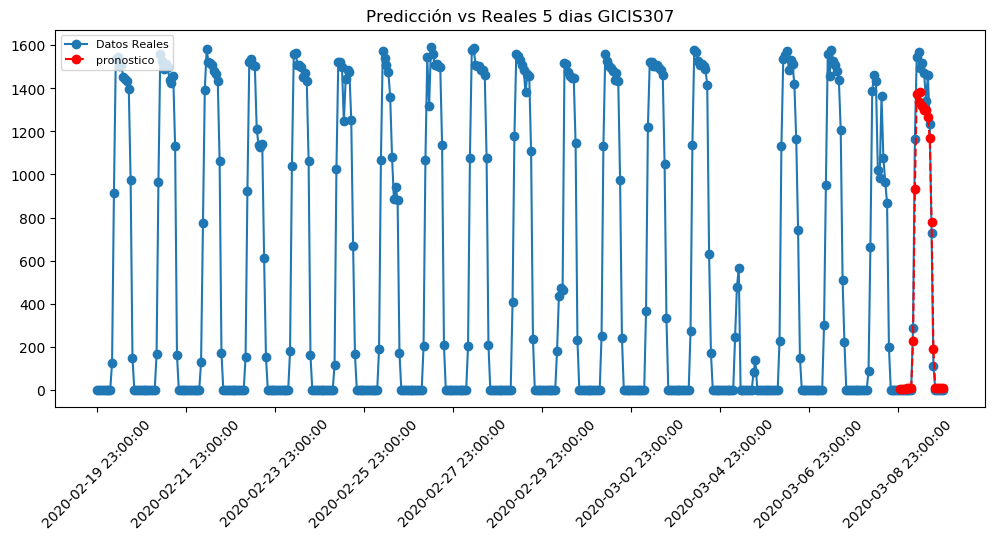

In [22]:
    arange_dates = []
    arange_no = []
    arange = datos[columna][-1-19*24:].index
    for i in range(0,len(arange),48):
        arange_dates.append(arange[i])
        arange_no.append(i)

    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(datos[columna][-1-19*24:], 'o-', label = 'Datos Reales')
    plt.plot(pronostico, 'o--', label='pronostico',color ='r')
    plt.title('Predicción vs Reales 5 dias '+columna)
    plt.xticks(arange_no,arange_dates,rotation = 45)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [33]:
Forecasts = pd.DataFrame(fc)
Forecasts

,0
0,1.981433
1,3.581564
2,4.873713
3,5.917159
4,6.759771
5,7.440202
6,7.989669
7,226.461733
8,933.760831
9,1374.957718


In [35]:
test.columns

Index(['hora', 'GICIS307'], dtype='object')

In [63]:
Forecasts.index = test.index
Forecasts.columns = [columna]
Forecasts = round(Forecasts,2)

,GICIS307
fecha_hora,
2020-03-09 00:00:00,1.98
2020-03-09 01:00:00,3.58
2020-03-09 02:00:00,4.87
2020-03-09 03:00:00,5.92
2020-03-09 04:00:00,6.76
2020-03-09 05:00:00,7.44
2020-03-09 06:00:00,7.99
2020-03-09 07:00:00,226.46
2020-03-09 08:00:00,933.76


In [68]:
len(Forecasts.values.flatten()), len(test.values.flatten())

(24, 48)

In [75]:
fvst = pd.DataFrame()
fvst['real'] = test[columna].values.flatten()
fvst['forecasts'] = Forecasts.values.flatten()

fvst

,real,forecasts
0,0.0,1.98
1,0.0,3.58
2,0.0,4.87
3,0.0,5.92
4,0.0,6.76
5,0.0,7.44
6,0.0,7.99
7,285.0,226.46
8,1166.0,933.76
9,1547.0,1374.96


In [38]:
new_mapes = np.abs((Forecasts - test) / test)
new_mapes[new_mapes == inf] = 0

In [43]:
new_mapes = new_mapes.drop(['hora'], axis =1)
new_mapes

,GICIS307
fecha_hora,
2020-03-09 00:00:00,0.000000
2020-03-09 01:00:00,0.000000
2020-03-09 02:00:00,0.000000
2020-03-09 03:00:00,0.000000
2020-03-09 04:00:00,0.000000
2020-03-09 05:00:00,0.000000
2020-03-09 06:00:00,0.000000
2020-03-09 07:00:00,0.205397
2020-03-09 08:00:00,0.199176


In [49]:
new_mapes.iloc[7:19,:]

,GICIS307
fecha_hora,
2020-03-09 07:00:00,0.205397
2020-03-09 08:00:00,0.199176
2020-03-09 09:00:00,0.111210
2020-03-09 10:00:00,0.147352
2020-03-09 11:00:00,0.075334
2020-03-09 12:00:00,0.131376
2020-03-09 13:00:00,0.115358
2020-03-09 14:00:00,0.029408
2020-03-09 15:00:00,0.133311


In [76]:
mea = np.mean(new_mapes.iloc[7:19,:])
mea

GICIS307    0.161464
dtype: float64

In [53]:
np.mean(mea)

0.08073221619297037

In [54]:
import pandas as pd
medidasdepresicion = ['MAD','MAPE','PMAD','MSE','RMSE']
dfpresicion = pd.DataFrame(columns=medidasdepresicion)
dfpresicion.MAPE = 0.2
dfpresicion

,MAD,MAPE,PMAD,MSE,RMSE
